In [ ]:
# Group 14
# 20CS10038 : N Surya Prakash Reddy
# Project 2
# Taxi Fare Prediction Using Neural Networks

In [ ]:
%pip install numpy
%pip install pandas
%pip install matplotlib
%pip install itertools

ERROR: Could not find a version that satisfies the requirement itertools (from versions: none)
ERROR: No matching distribution found for itertools


In [1]:
import csv
import numpy as np
from itertools import chain
from sklearn.neural_network import MLPRegressor
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from math import cos, asin, sqrt, pi



In [2]:
# import filterwarnings
from warnings import filterwarnings

filterwarnings('ignore')

# Helping functions implementation

In [3]:
# take an np array x and return values at indices
def get_val_at_indices(x, indices):
    return x[indices]

def train_test_split(*arrays, test_size=0.25, shufffle=True, random_state=42):
    # get length of first array
    length = len(arrays[0])

    # split lengths
    len_test = int(np.ceil(length*test_size))
    len_train = length - len_test

    if shufffle:
        perm = np.random.RandomState(random_state).permutation(length)
        test_indices = perm[:len_test]
        train_indices = perm[len_test:]
    else:
        train_indices = np.arange(len_train)
        test_indices = np.arange(len_train, length)

    return list(chain.from_iterable((get_val_at_indices(x, train_indices), get_val_at_indices(x, test_indices)) for x in arrays))

In [4]:
# Distance calculation function to use the latitudes and longitudes to find travel distance
def spherical_distance(lat1, lon1, lat2, lon2):
    r = 6371 # km
    p = pi / 180

    a = 0.5 - cos((lat2-lat1)*p)/2 + cos(lat1*p) * cos(lat2*p) * (1-cos((lon2-lon1)*p))/2
    return 2 * r * asin(sqrt(a))

# Custom Class Implementation

In [29]:
class CNN:
    def __init__(self, hidden_layer_sizes=(100,), learning_rate=0.1, epochs=200, batch_size=32, random_state=42, hidden_layer_activation='logistic', output_layer_activation='linear', optim_algo='SGD', loss_function='MSE', l2_lamda=0):
        # learning rate should be casted to np.float64
        self.learning_rate = np.float64(learning_rate)
        self.l2_lamda = np.float64(l2_lamda)
        self.epochs = epochs
        self.batch_size = batch_size
        self.random_state = random_state
        self.hidden_layer_sizes = hidden_layer_sizes
        self.is_first_pass = True

        # Activation functions for hidden layer
        if hidden_layer_activation == 'logistic':
            self.hidden_layer_activation = self.sigmoid
            self.hidden_layer_activation_derivative = self.sigmoid_derivative
        elif hidden_layer_activation == 'ReLU':
            self.hidden_layer_activation = self.ReLU
            self.hidden_layer_activation_derivative = self.ReLU_derivative
        elif hidden_layer_activation == 'linear':
            self.hidden_layer_activation = self.linear
            self.hidden_layer_activation_derivative = self.linear_derivative
        else:
            # default to sigmoid
            self.hidden_layer_activation = self.sigmoid
            self.hidden_layer_activation_derivative = self.sigmoid_derivative

        # Activation functions for output layer
        if output_layer_activation == 'logistic':
            self.output_layer_activation = self.sigmoid
            self.output_layer_activation_derivative = self.sigmoid_derivative
        elif output_layer_activation == 'ReLU':
            self.output_layer_activation = self.ReLU
            self.output_layer_activation_derivative = self.ReLU_derivative
        elif output_layer_activation == 'linear':
            self.output_layer_activation = self.linear
            self.output_layer_activation_derivative = self.linear_derivative
        else:
            # default to sigmoid
            self.output_layer_activation = self.sigmoid
            self.output_layer_activation_derivative = self.sigmoid_derivative

        if optim_algo == 'SGD':
            self.optim_algo = self.msgd

        if loss_function == 'MSE':
            self.loss_function = self.MSE

    # train test split to store the train and test data
    def train_test_split(self, *arrays, test_size=0.25, shuffle=True):
        # get length of first array
        length = len(arrays[0])

        # split lengths
        len_test = int(np.ceil(length*test_size))
        len_train = length - len_test

        # If shuffle is added, permutates the indices and returns a pseudorandom
        # split that can be recreated
        if shuffle:
            perm = np.random.RandomState(self.random_state).permutation(length)
            test_indices = perm[:len_test]
            train_indices = perm[len_test:]
        else:
            train_indices = np.arange(len_train)
            test_indices = np.arange(len_train, length)

        # Unpack from the list of train and test indices
        self.X_train, self.X_test, self.y_train, self.y_test = list(chain.from_iterable((get_val_at_indices(x, train_indices), get_val_at_indices(x, test_indices)) for x in arrays))

    def sigmoid(self, x):
        # numpy has an overflow issue when np.exp(-x) for a large negative
        # number is calculated. So, for negatives we use
        # e^x/(1+e^x) instead.

        # Get positive and negative indices
        positives = x >= 0
        negatives = ~positives

        exp_x_neg = np.exp((x[negatives]).astype(np.float64))

        y = x.copy()

        y[positives] = 1 / (1 + np.exp((-x[positives]).astype(np.float64)))
        y[negatives] = exp_x_neg / (1 + exp_x_neg)

        return y

    def sigmoid_derivative(self, X):
        return X * (1-X)

    def ReLU(self, X):
        return np.maximum(0, X)

    def ReLU_derivative(self, X):
        return 1 * (X > 0)

    def linear(self, X):
        return X

    def linear_derivative(self, X):
        return 1

    # Divides the dataset indices into self.batch_sized minibatches
    def load_data(self):
        mini_batches = []

        train_size = self.X_train.shape[0]

        num_batches = int(np.ceil(train_size / self.batch_size))

        for i in range(num_batches):
            start = i * self.batch_size
            end = start + self.batch_size

            if end > train_size:
                end = train_size

            mini_batches.append(((start, end)))

        return mini_batches

    # MSE loss
    def MSE(self, y, y_pred):
        # Reshape to avoid numpy dimensionality issues
        if len(y.shape) == 1:
            y = y.reshape(-1, 1)

        return np.mean((y - y_pred)**2) / 2

    # Mini batch gradient descent implementation
    def msgd(self):
        # Initialise all activation layers and deltas
        activations = [None] * (self.num_layers)
        deltas = [None] * (self.num_layers-1)

        # Get minibatch indices
        mini_batches = self.load_data()

        # Train and Test losses for plotting
        train_losses = []
        test_losses = []

        # For each epoch
        for i in range(self.epochs):
            # Since batch sizes may not be consistent, we use this variable and
            # take a mean over all batches towards the end
            epoch_loss = 0
            for mini_batch in mini_batches:
                # For each minibatch, set first activations layer to X_train[mb]
                start, end = mini_batch

                activations[0] = self.X_train[start:end]

                # Forward propagation
                activations = self.forward(activations)

                # print(f"activation: {activations[0][0]}, {activations[-1][0]}")
                # Every 10th epoch, calculate and store epoch losses
                if i%10 == 9 and self.plot_losses:
                    # multiply by mini batch size since loss fn is mean over the whole batch
                    epoch_loss += self.loss_function(self.y_train[start:end], activations[-1]) * (end-start+1)

                # backpropagate with activations and deltas
                self.backward(activations, deltas, self.y_train[start:end], (end-start+1))

            # Every 10 epochs, calculate losses and append to train_losses, test_losses
            if i%10 == 9 and self.plot_losses:
                # Take a mean over the whole batch
                train_losses.append(epoch_loss / self.X_train.shape[0])
                y_pred = self.predict(self.X_test)
                test_losses.append(self.loss_function(self.y_test, y_pred))

        self.train_losses = train_losses
        self.test_losses = test_losses

    # Initializes weights and biases using layer sizes
    def weight_initialization(self, layer_sizes):
        self.weights = []
        self.biases = []

        # For input_layer:hidden_layer_1 and hidden_layer_i:hidden_layer_i++
        for i in range(self.num_layers - 1):
            weight, bias = self.add_layer(layer_sizes[i], layer_sizes[i+1])

            self.weights.append(weight)
            self.biases.append(bias)

    # Returns weights and bias as 2D np arrays of shape (input_size, output_size) with values randomly
    # Between -1 and 1
    def add_layer(self, input_size, output_size):
        # Seed with initialized random state for consistency
        np.random.seed(self.random_state)
        weight = np.array(((np.random.rand(input_size, output_size) - 0.5) * 2), dtype=np.float64)
        bias = np.array(((np.random.rand(1, output_size) - 0.5) * 2), dtype=np.float64)
        return weight, bias

    # If this is the first training pass, call for weight_initialization
    def first_pass(self, layer_sizes):
        self.num_layers = len(layer_sizes)

        self.weight_initialization(layer_sizes)

    # Forward pass
    def forward(self, activations):
        # For each layer, calculate Z as A[i].W[i] and convert to activations
        for i in range(self.num_layers-1):
            # if not output layer, apply hidden layer activation function
            if i != self.num_layers-2:
                activations[i+1] = self.hidden_layer_activation(np.dot(activations[i], self.weights[i]) + self.biases[i])
            else:
                activations[i+1] = self.output_layer_activation(np.dot(activations[i], self.weights[i]) + self.biases[i])

        return activations

    # Backward pass
    def backward(self, activations, deltas, y, current_batch_size):
        # Deltas for output layer = loss_fn_derivate * activation_derivative
        deltas[self.num_layers-2] = (y - activations[-1]) * self.output_layer_activation_derivative(activations[-1])

        # Update weights using chain rule
        self.weights[self.num_layers-2] += (np.dot(activations[self.num_layers-2].T, deltas[self.num_layers-2]).astype(np.float64) / current_batch_size) * self.learning_rate - self.l2_lamda * self.learning_rate * self.weights[self.num_layers-2]
        self.biases[self.num_layers-2] += (np.sum(deltas[self.num_layers-2], axis=0).astype(np.float64) / current_batch_size) * self.learning_rate

        # For each hidden layer until the input layer use chain rule to get deltas
        for i in range(self.num_layers-2, 0, -1):
            deltas[i-1] = np.dot(deltas[i], self.weights[i].T) * self.hidden_layer_activation_derivative(activations[i])

            self.weights[i-1] += (np.dot(activations[i-1].T, deltas[i-1]).astype(np.float64) / current_batch_size) * self.learning_rate - self.l2_lamda * self.learning_rate * self.weights[i-1]
            self.biases[i-1] += (np.sum(deltas[i-1], axis=0).astype(np.float64) / current_batch_size) * self.learning_rate

    # Checks for train test split, initialising weights, running the algorithm and plotting the losses
    def train(self, plot_losses=False):
        if not hasattr(self, 'X_train') or not hasattr(self, 'y_train'):
            raise AttributeError('X_train and y_train not found. Please run train test split first.')

        self.plot_losses = plot_losses

        # if y is 1D, convert to 2D
        if len(self.y_train.shape) == 1:
            self.y_train = self.y_train.reshape(-1, 1)

        # Initialize weights and biases if it's the first pass
        if self.is_first_pass:
            self.first_pass([self.X_train.shape[1]] + list(self.hidden_layer_sizes) + [self.y_train.shape[1]])
            self.is_first_pass = False

        # Train using the optimization algorithm set while initializing the model
        self.optim_algo()

        if plot_losses:
            x_indices = range(len(self.train_losses))

            plot_labels = [i+1 for i in range(self.epochs) if i%10 == 9]

            plt.figure(figsize=(10, 6))
            plt.plot(x_indices, self.train_losses, label='Train Losses')
            plt.plot(x_indices, self.test_losses, label='Test Losses')
            plt.xticks(x_indices, plot_labels)

            plt.xlabel('Epochs')
            plt.ylabel('Losses')
            plt.title('Train Tess Loss at every 10 epochs')
            plt.legend()
            plt.show()

    # Just a forward pass but since we don't need to store each activation layer
    # in a list, this is faster
    def predict(self, X):
        activation = X

        for i in range(self.num_layers-1):
            activation = np.dot(activation, self.weights[i]) + self.biases[i]

            if i != self.num_layers-2:
                activation = self.hidden_layer_activation(activation)
            else:
                activation = self.output_layer_activation(activation)

        return activation

    # Returns r2 score for the model
    def score(self, y, y_pred):
        if len(y.shape) == 1:
            y = y.reshape(-1, 1)

        y_mean = np.mean(y)
        ss_res = np.sum((y - y_pred) ** 2)
        ss_tot = np.sum((y - y_mean) ** 2)

        return 1 - (ss_res/ss_tot)

# Main

## Reading data

In [6]:
data_file = "/content/taxi.csv"

In [7]:
with open(data_file, 'r') as f:
    data = list(csv.reader(f))

    # ignore first row(headers) and first 2 columns(key, sno) and get the list
    data = [row[2:] for row in data[1:]]

    # If we find data that is either not there or not valid, we remove them
    deleted = []

    """
        Instead of using the lats and lons directly as input to the neural network,
        we first convert them to travel_distance since lats and lons are not really
        linearly related to fares. Fares with zero displacement are also removed since
        the dependence is only on date which doesn't make sense for prediction.

        The date is split into two parts, time of the day and day of the week.
        Time is normalized so that it doesn't have complete influence over the
        Z values(A.W)
    """

    for i in range(len(data)):
        # for each value in column 2 of the form YYYY-MM-DD HH:MM:SS, convert to a value of 60*HH + MM to denote time of the day
        date = data[i][1].split(' ')
        time = date[1].split(':')
        data[i][1] = np.float64((int(time[0])*60 + int(time[1]))/100)

        data_point = data[i]

        distance = 0

        # add a new column to denote the day of the week
        data_point.append(np.float64((int(date[0].split('-')[2]) % 7) + 1))

        # if both pickup and dropoff latitude and longitude are 0, delete the row
        # Else, set the pickup latitude and longitude to the dropoff latitude and longitude
        if data_point[2] == '0.0':
            if data_point[4] == '0.0':
                deleted.append(i)
                continue
            else:
                data_point[2] = data_point[4]
        elif data_point[4] == '0.0':
            data_point[4] = data_point[2]

        if data_point[3] == '0.0':
            if data_point[5] == '0.0':
                deleted.append(i)
                continue
            else:
                data_point[3] = data_point[5]
        elif data_point[5] == '0.0':
            data_point[5] = data_point[3]

        delete = False

        for j in range(len(data_point)):
            try:
                data_point[j] = float(data_point[j])
            except:
                # Exceptions occur when the value is empty or not a number
                deleted.append(i)
                delete = True

        if delete:
            continue

        # Now calculate the distance between the pickup and dropoff points
        distance = spherical_distance(float(data_point[3]), float(data_point[2]), float(data_point[5]), float(data_point[4]))

        if distance == 0:
            deleted.append(i)
            continue

        data_point.append(distance)

    # remove the latitude and longitude columns and the deleted rows
    data = [data[i] for i in range(len(data)) if i not in deleted]

    columns = [0, 1, 6, 7, 8]

    data = np.array([[row[i] for i in columns] for row in data])

print(data.shape)
print(data[0])

(194006, 5)
[ 7.5        11.92        1.          1.          1.68332275]


## Pre Processing

In [8]:
# fares is the first column values
y = data[:, 0]

# features are the rest of the columns
X = data[:, 1:]

print(f"X: {X.shape}, y: {y.shape}")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")

# Delete data variable since it is no longer needed
del data

X: (194006, 4), y: (194006,)
X_train: (155204, 4), y_train: (155204,)



## Case 1

* No of hidden layers: 1
* No. of neurons in hidden layer: 32
* Activation function in the hidden layer: Sigmoid
* 1 neuron in the output layer.
* Activation function in the output layer: Linear
* Optimisation algorithm: Mini Batch Stochastic Gradient Descent (SGD)
* Loss function: Mean Squared Error (MSE)
* Learning rate: 0.01
* No. of epochs = 200

### Custom Class Implementation

In [49]:
CustomNN = CNN(
        hidden_layer_sizes=(32,),
        hidden_layer_activation='logistic',
        output_layer_activation='linear',
        optim_algo='SGD',
        loss_function='MSE',
        learning_rate=0.01,
        epochs=200,
        random_state=42,
    )

Data Loading

In [50]:
# Load data into the model with split size 80:20
CustomNN.train_test_split(X, y, test_size=0.2)

Training the model. Weight initialisation is also included since this is the first pass.

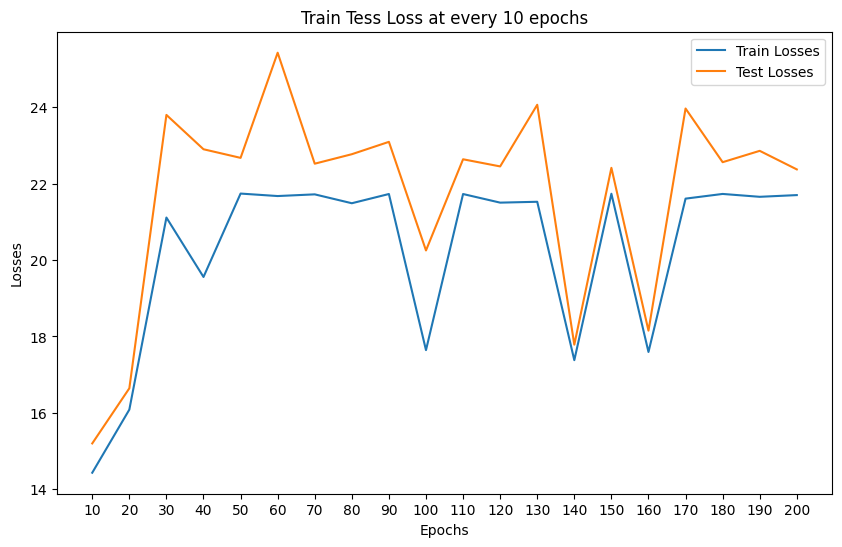

In [51]:
# Call train loop
CustomNN.train(plot_losses=True)

In [33]:
print(f"train score for the custom model: {CustomNN.score(y_train, CustomNN.predict(X_train))}")

train score for the custom model: 0.5706652533644992


In [35]:
test_score = CustomNN.score(y_test, CustomNN.predict(X_test))

print(f"test score for the custom model: {test_score}")

test score for the custom model: 0.5476801822108012


### Sklearn Implementation

In [36]:
MLP = MLPRegressor(
    hidden_layer_sizes=(32,),
    activation='logistic',
    solver='sgd',
    learning_rate_init=0.01,
    max_iter=200,
    random_state=42
)

Training the model using X_train and y_train

In [38]:
MLP.fit(X_train, y_train)

print(f"Train score for the MLP model: {MLP.score(X_train, y_train)}")

Train score for the MLP model: 0.5785410418301786


Testing the model using X_test

In [39]:
print(f"Test score for MLP model {MLP.score(X_test, y_test)}")


Test score for MLP model 0.5574149450460854


## Case 2
* No of hidden layers: 2
* No. of neurons in the 1st hidden layer: 64
* No. of neurons in the 2nd hidden layer: 32
* Activation function in both the hidden layers: ReLU
* 1 neuron in the output layer.
* Activation function in the output layer: Linear
* Optimisation algorithm: Mini Batch Stochastic Gradient Descent (SGD)
* Loss function: Mean Squared Error (MSE)
* Learning rate: 0.01
* No. of epochs = 200

### Custom Class Implementation

In [40]:
CustomNN = CNN(
        hidden_layer_sizes=(64, 32,),
        hidden_layer_activation='Relu',
        output_layer_activation='linear',
        optim_algo='SGD',
        loss_function='MSE',
        learning_rate=0.01,
        epochs=200,
        random_state=42,
        l2_lamda=0.001
    )

In [41]:
CustomNN.train_test_split(X, y)

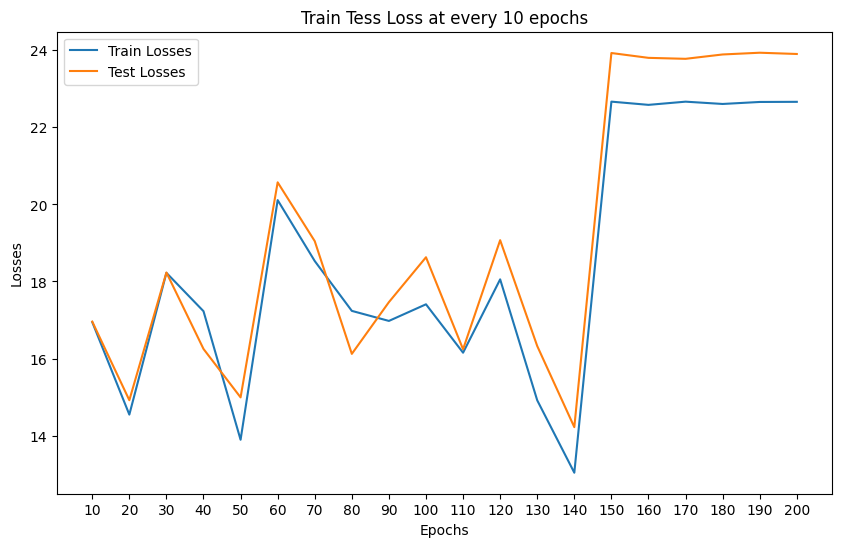

Train score for the custom model: 0.5362440788227133


In [42]:
CustomNN.train(plot_losses=True)

print(f"Train score for the custom model: {CustomNN.score(y_train, CustomNN.predict(X_train))}")

In [44]:
test_score = CustomNN.score(y_test, CustomNN.predict(X_test))

print(f"Test score for the custom model: {test_score}")

Test score for the custom model: 0.5137340892948749


### SkLearn Implementation

In [45]:
MLP = MLPRegressor(
    hidden_layer_sizes=(64,32,),
    activation='relu',
    solver='sgd',
    learning_rate_init=0.01,
    max_iter=200,
    random_state=42
)

In [46]:
MLP.fit(X_train, y_train)

print(f"Train score for the MLP model: {MLP.score(X_train, y_train)}")

Train score for the MLP model: -0.000275119310358507


In [47]:
pred = MLP.predict(X_test)

print(f"Test score for MLP model {MLP.score(X_test, y_test)}")


Test score for MLP model -0.00042094729698116673
